In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import gym

In [2]:
env = gym.make('CartPole-v1')

assert isinstance(env.observation_space, gym.spaces.Box)
assert isinstance(env.action_space, gym.spaces.Discrete)

In [3]:
SEED = 1234

env.seed(SEED);
np.random.seed(SEED);
torch.manual_seed(SEED);

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.25):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [5]:
INPUT_DIM = env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

In [6]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)
        
actor.apply(init_weights)
critic.apply(init_weights)

MLP(
  (fc_1): Linear(in_features=4, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.25)
)

In [7]:
LEARNING_RATE = 0.01

actor_optimizer = optim.Adam(actor.parameters(), lr = LEARNING_RATE)
critic_optimizer = optim.Adam(critic.parameters(), lr = LEARNING_RATE)

In [8]:
def train(env, actor, critic, actor_optimizer, critic_optimizer, discount_factor):
    
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)
        
        action_preds = actor(state)
        value_pred = critic(state)
            
        action_probs = F.softmax(action_preds, dim = -1)
                
        dist = distributions.Categorical(action_probs)

        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)
        
        state, reward, done, _ = env.step(action.item())

        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)

        episode_reward += reward

    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)
        
    returns = calculate_returns(rewards, discount_factor)
    
    policy_loss, value_loss = update_policy(returns, log_prob_actions, values, actor_optimizer, critic_optimizer)

    return policy_loss, value_loss, episode_reward

In [9]:
def calculate_returns(rewards, discount_factor, normalize = True):
    
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r +  R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    
    if normalize:
        returns = (returns - returns.mean()) / returns.std()
        
    return returns

In [10]:
def update_policy(returns, log_prob_actions, values, actor_optimizer, critic_optimizer):

    returns = returns.detach()
    
    policy_loss = - (returns * log_prob_actions).mean()
    
    value_loss = F.smooth_l1_loss(returns, values).mean()
    
    actor_optimizer.zero_grad()
    critic_optimizer.zero_grad()
    
    policy_loss.backward()
    value_loss.backward()
    
    actor_optimizer.step()
    critic_optimizer.step()
    
    return policy_loss.item(), value_loss.item()

In [11]:
MAX_EPISODES = 500
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 10

episode_rewards = []

for episode in tqdm(range(1, MAX_EPISODES+1)):
    
    policy_loss, critic_loss, episode_reward = train(env, actor, critic, actor_optimizer, critic_optimizer, DISCOUNT_FACTOR)
    
    episode_rewards.append(episode_reward)
    
    mean_trial_rewards = np.mean(episode_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
    
        print(f'| Episode: {episode:4} | Mean Rewards: {mean_trial_rewards:6.2f} |')
    
    if mean_trial_rewards >= REWARD_THRESHOLD:
        
        print(f'Reached reward threshold in {episode} episodes')
        
        break

| Episode:   10 | Mean Rewards:  40.00 |
| Episode:   20 | Mean Rewards:  46.95 |
| Episode:   30 | Mean Rewards:  70.32 |
| Episode:   40 | Mean Rewards: 109.28 |
| Episode:   50 | Mean Rewards: 158.20 |
| Episode:   60 | Mean Rewards: 224.60 |
| Episode:   70 | Mean Rewards: 269.40 |
| Episode:   80 | Mean Rewards: 283.20 |
| Episode:   90 | Mean Rewards: 258.28 |
| Episode:  100 | Mean Rewards: 237.28 |
| Episode:  110 | Mean Rewards: 341.16 |
| Episode:  120 | Mean Rewards: 455.40 |
Reached reward threshold in 123 episodes


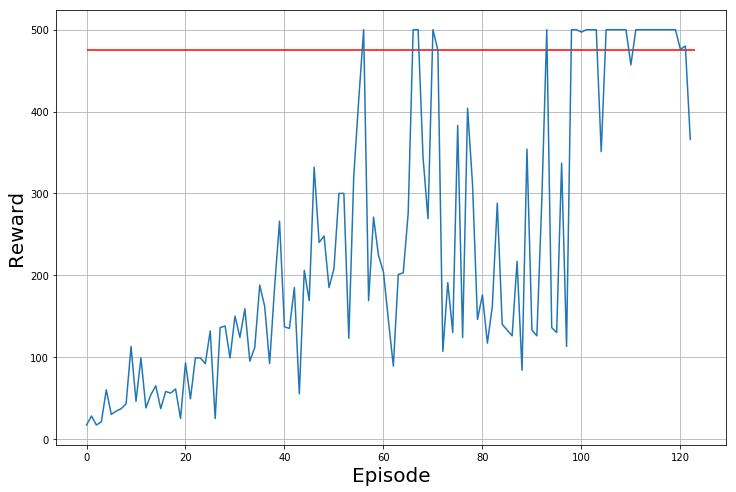

In [12]:
plt.figure(figsize=(12,8))
plt.plot(episode_rewards)
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(episode_rewards), color='r')
plt.grid()